# Simulation of a two-floor building
**Author** : Roger Hiltebrand \
**School** : ZHAW SoE, Winterthur \
**Module** : EVA Dynamic Models for Building Energy Management \
**Date**   : 20.11.2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Building description

## Description of situation and definition of geometry

The model to be simulated is a 2-storey building with window panes on one side. It stands on the ground and has no insulation to the earth, only the foundation serves as insulation. In both rooms, one above the other, an HVAC system is installed, which can heat and cool the room. These are controlled by a thermostat (set temperature). In addition, there is a ventilation system that renews the air in the room. The rooms are separated from each other by a layer of concrete, so they are not insulated from each other. All external walls are of the same thickness and have external insulation to protect against cold and heat from outside.<br />
The geometric parameters of the house are defined as follows:

In [2]:
l = 10      # length of th house in meters
b = 5       # width of the house in meters
h = 2.5     # height of a Room in meters
Sw1 = 2 * l * h  # Surface of the side Walls
Sw2 = b * h  # Surface of the Windows and opposite Wall
Sg = l * b   # Surface of the Roof and grounds
V1 = l * b * h  # Volume of one Room

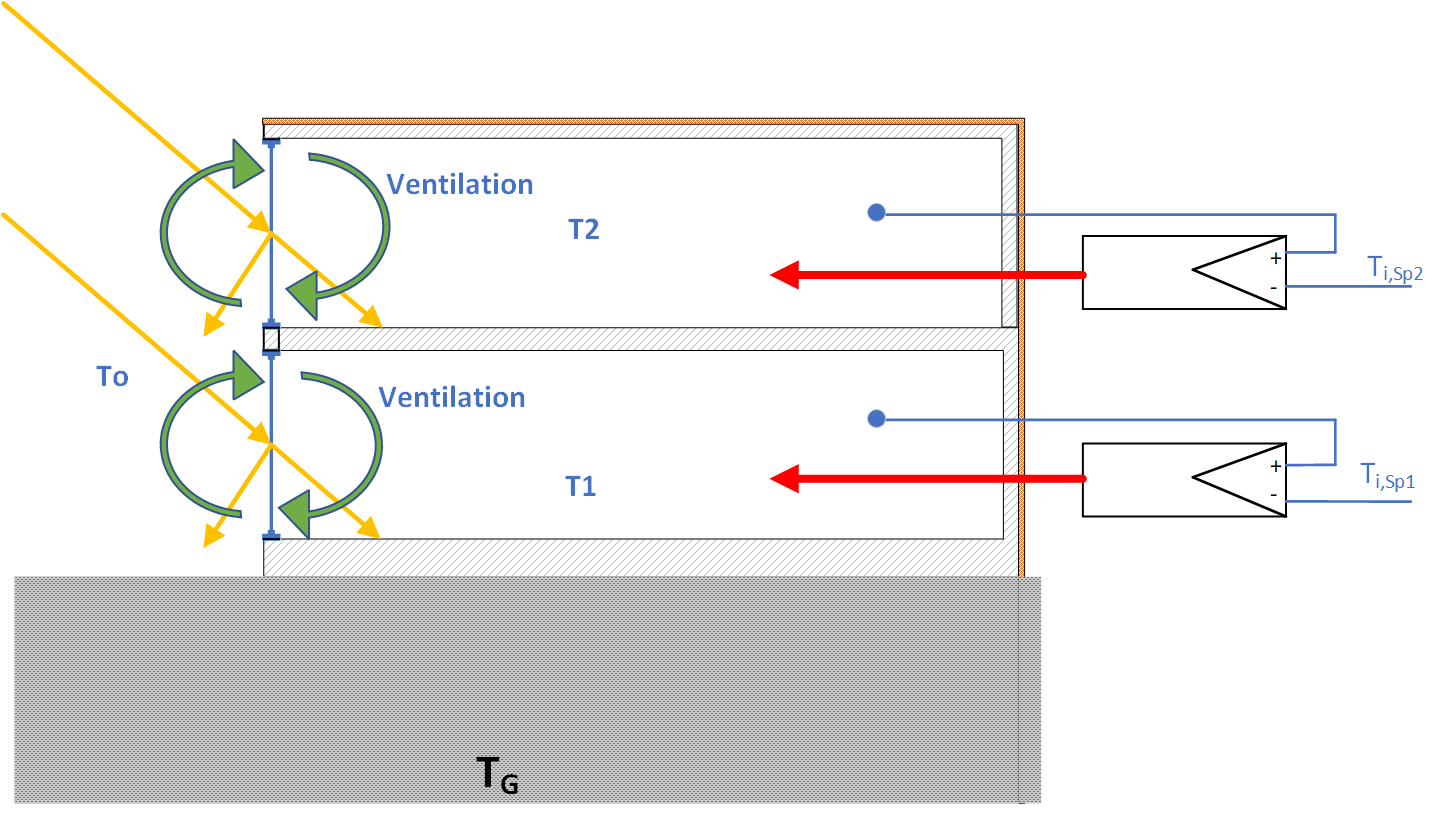
>Figure 1: Representation of the building to be simulated. It has insulated concrete walls and a glass front. The floor is not insulated against the ground.

## Definiton of the thermo-physical properties

Table 1 and 2 below show the parameters used for all solid and gaseous substances in the model. In order for the earth temperature to be considered constant in the later course, a 3m thick layer of earth was taken into account. The parameters for the soil in Table 1 therefore refer to a layer 1m wide. Since a different density can result depending on the composition of the soil, the [soil density](https://www.schweizer-fn.de/stoff/wkapazitaet/wkapazitaet_baustoff_erde.php) is assumed to be 2000kg/m³. The same applies to the property of thermal [conductivity](https://www.heizungsfinder.de/waermepumpe/sole-wasser/erdreich), depending on the soil property, it can vary from 1W/(m·K) - 6W/(m·K), here, therefore, a value of 1.5W/(m·K) was assumed, which should be in the range for sandy rock and clayey soil. For the [specific heat capacity](https://www.schweizer-fn.de/stoff/wkapazitaet/wkapazitaet_baustoff_erde.php), the same values were used for the soil and the concrete. For the soil, an assumption had to be made again, as this value also depends on various factors (moisture, density, elements). As a reference point for the [specific heat capacity](https://www.schweizer-fn.de/stoff/wkapazitaet/wkapazitaet_baustoff_erde.php) and the [thermal conductivity](https://www.schweizer-fn.de/stoff/wleit_isolierung/wleit_isolierung.php#wleitf_mauerwerk) for the other elements, assumptions were made that are in the range of the values of the real building materials. 

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

wall = {'Conductivity': [1.5, 1.4, 1.4, 1.4, 1.4, 1.4,
                         0.03, 0.03, 0.03, 1.4],  # W/(m·K)
        'Density': [2000, 2000, 2000, 2000, 2000, 2000,
                    55, 55, 55, 2500],  # kg/m³
        'Specific heat': [1000, 1000, 1000, 1000, 1000, 1000,
                          1210, 1210, 1210, 750],  # J/(kg·K)
        'Width': [1, 0.5, 0.3, 0.2, 0.2, 0.2, 0.08, 0.08, 0.08, 0.004],
        'Surface': [Sg, Sg, Sg, Sg, Sw1, Sw2, Sw1, Sw2, Sg, Sw2],  # m²
        'Slices': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}       # number of  slices
wall = pd.DataFrame(wall, index=['ground', 'Concrete_ground', 'Concrete_mid',
                                 'Concrete_roof', 'Concrete1',
                                 'Concrete2', 'Insulation1',
                                 'Insulation2', 'Insulation_roof', 'Glass'])

>Table 1: Definition of the different solid elements and its thermo-physical properties of the model. 

In [4]:
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
ground,1.50,2000,1000,1.000,50.0,1
Concrete_ground,1.40,2000,1000,0.500,50.0,1
Concrete_mid,1.40,2000,1000,0.300,50.0,1
Concrete_roof,1.40,2000,1000,0.200,50.0,1
Concrete1,1.40,2000,1000,0.200,50.0,1
Concrete2,1.40,2000,1000,0.200,12.5,1
Insulation1,0.03,55,1210,0.080,50.0,1
Insulation2,0.03,55,1210,0.080,12.5,1
Insulation_roof,0.03,55,1210,0.080,50.0,1
Glass,1.40,2500,750,0.004,12.5,1


> Table 2: Definition of the air's thermo-physical properties.

In [5]:
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


## Optical parameters

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces are:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (between normal and rough), wooden floor surfaces and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) of white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [6]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_wLWf = 0.885  # long wave emmisivity: floor surface (wood color)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

### Viewfactor F definition

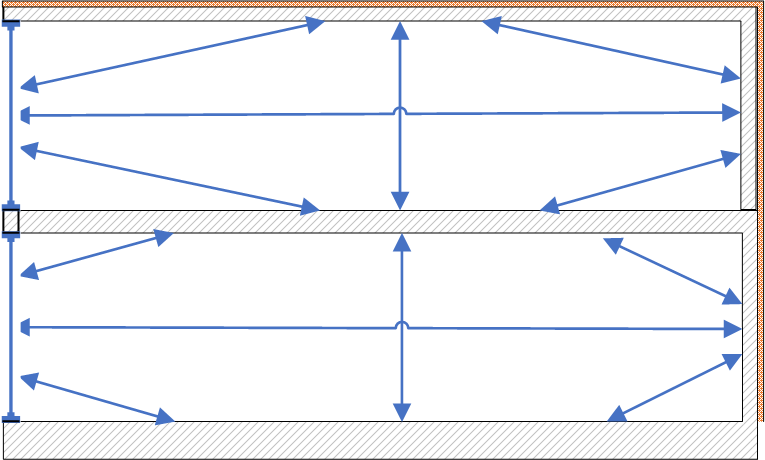
>Figure 2: Walls, floors and ceilings that can see each other and have a view factor.

The calculated values for each situation were read from corresponding diagrams [1]. For this simulation there were just two different situations:
- Two parallel surfaces
- Two orthogonal surfaces

In [7]:
F = np.zeros([4, 4])
F[0, 1] = F[0, 3] = 0.075  # Viewfactor glass-ground/ceiling
F[2, 3] = F[2, 1] = 0.055  # Viewfactor wall-ground/ceiling
F[0, 2] = 1 - F[0, 1] - F[0, 3]  # Viewfactor glass-wall
F[1, 3] = F[3, 1] = 0.52   # Viewfactor roof-ground

# Hypothesis

The aim of this work is to develop a model for a 2-storey building built directly on the ground. A thermal simulation will be performed to understand how the heating behaviour of one room affects the temperature in the other room.

## Building location
The building is located near the city of Zurich in Switzerland. For this, [Climate.OneBuilding.Org](http://climate.onebuilding.org) used weather data from the measuring station in Zurich Affoltern. Only the solar radiation and the outside temperature are considered in this simulation. The ground temperature is assumed to be constant at a depth of 3 m.





# Thermal Circuit 
In this simulation there are heat transfers:
- through the walls, roof and floor (concrete and insulation), 
- through the glass window,
- by ventilation,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. 
There is long wave radiative exchange between:
- the wall and the glass window,
- the wall and the floor,
- the wall and the ceiling,
- the glass window and the floor,
- the glass window and the ceiling.

The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
    - Ground tmperature in 3 m depth;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;

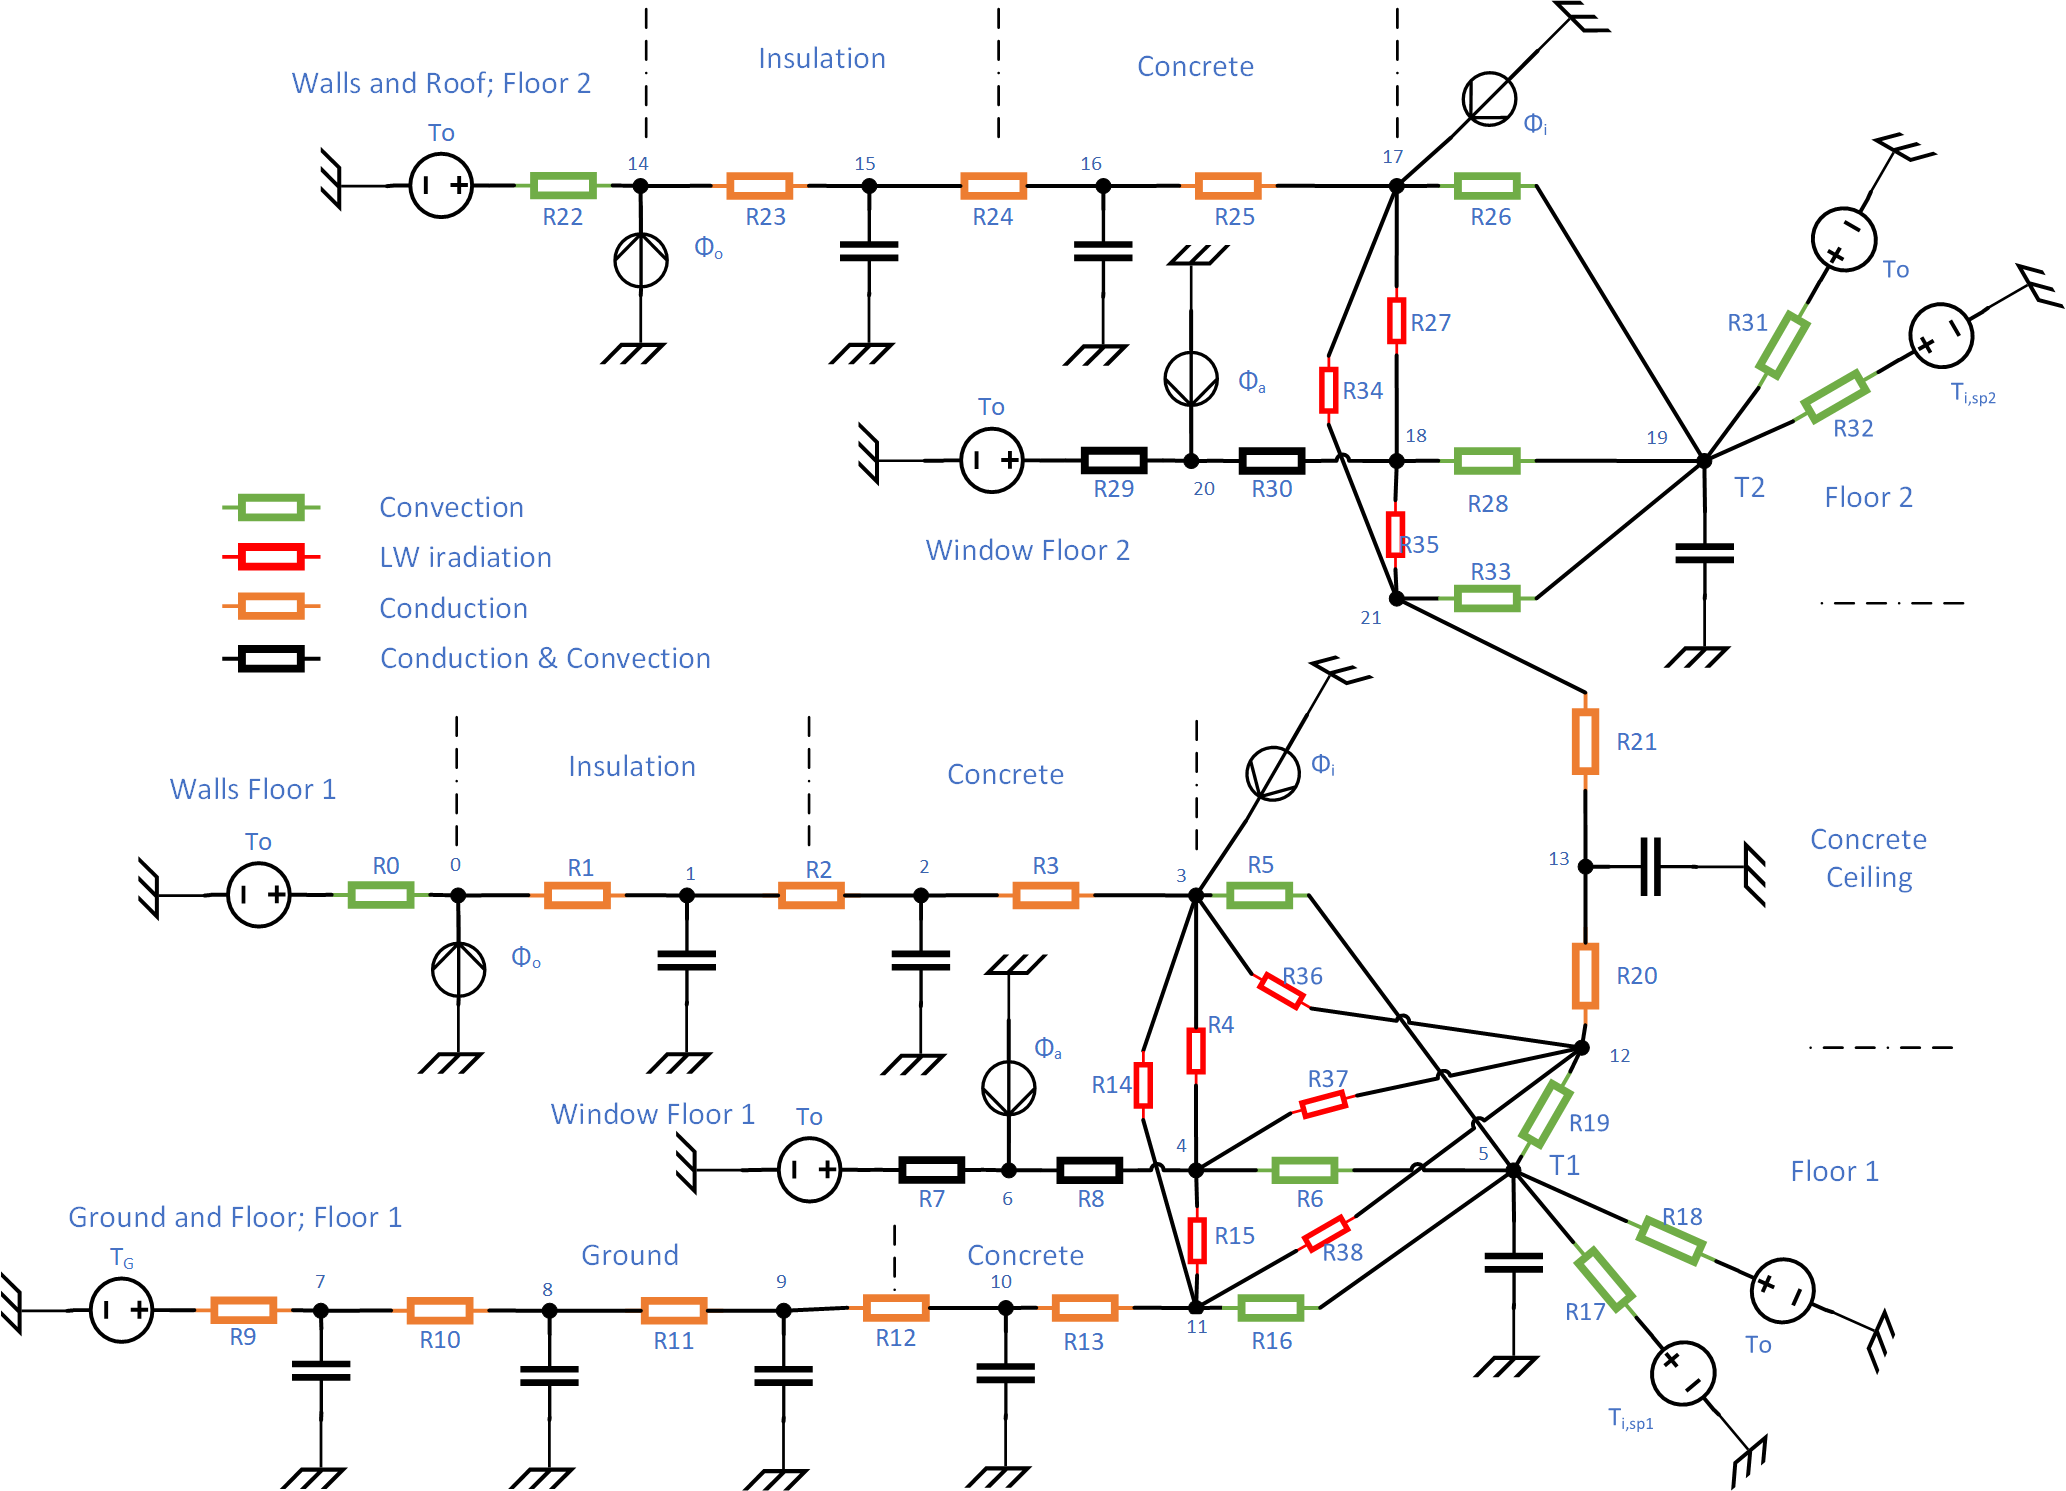
>Figure 3: Thermal circuit of the simulated building. The different colours of the conductances ar indicating the type of heat flow as shown in the legend.

Figure 3 shows the models of:
- concrete & insulation wall for the floor 1; from branch 0;
- concrete & insulation wall and roof for the floor 2: from branch 22;
- glass windows for each floor: from branch 7 and 29;
- ventilation of each floor: from branch 17 and 31;
- indoor volume: branches to node 5 and 19;
- HVAC system: from branches 18 and 32.

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp1}$ - setpoint temperaure for the indoor air of floor 1, °C;
- $T_{i,sp2}$ - setpoint temperaure for the indoor air of floor 2, °C;
- $T_{G}$ - setpoint temperaure for the ground at 3 m depth, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

The model consists out of 39 branches and 22 temperature nodes.

In [8]:
brn = 39  # number of branches
nds = 22  # number of nodes

## Definition of the thermal resistances

### Conduction resistances
The resistances 0, 5, 6, 16 - 19, 22, 26, 28 and 31 - 33 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$R_{cd} = \frac{w}{\lambda*S}$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [9]:
# define the Thermal conductances
R_cd = wall['Width'] / (wall['Conductivity'] * wall['Surface'])

### Convection resistance
The resistances 1 - 3, 9 - 13, 20, 21 and 23 - 25 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$R_{cv} = \frac{1}{conp * S}$$
where:
- $conp$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [10]:
# convection parameters for the air
conp = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

In [11]:
Rgr = 1 / (conp.iloc[0]['in'] * wall['Surface'][1])     # concrete ground
Rmid1 = 1 / (conp.iloc[0]['in'] * wall['Surface'][2])  # concrete middle ceiling
Rmid2 = 1 / (conp.iloc[0]['in'] * wall['Surface'][2])   # concrete middle floor
Rroof = 1 / (conp * wall['Surface'][3])    # concrete middle roof/ground
Rw1 = 1 / (conp * wall['Surface'][4])     # wall on the side
Rw2 = 1 / (conp * wall['Surface'][5])     # wall on the opposide of the window
Rg = 1 / (conp * wall['Surface'][9])     # from the glass

### Long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) and then linearizing the radiative heat exchange. In the thermal model they are shown by the resistances 4, 14, 15, 27, 34 - 38. How they are connected to each other is shown in Figure 4.

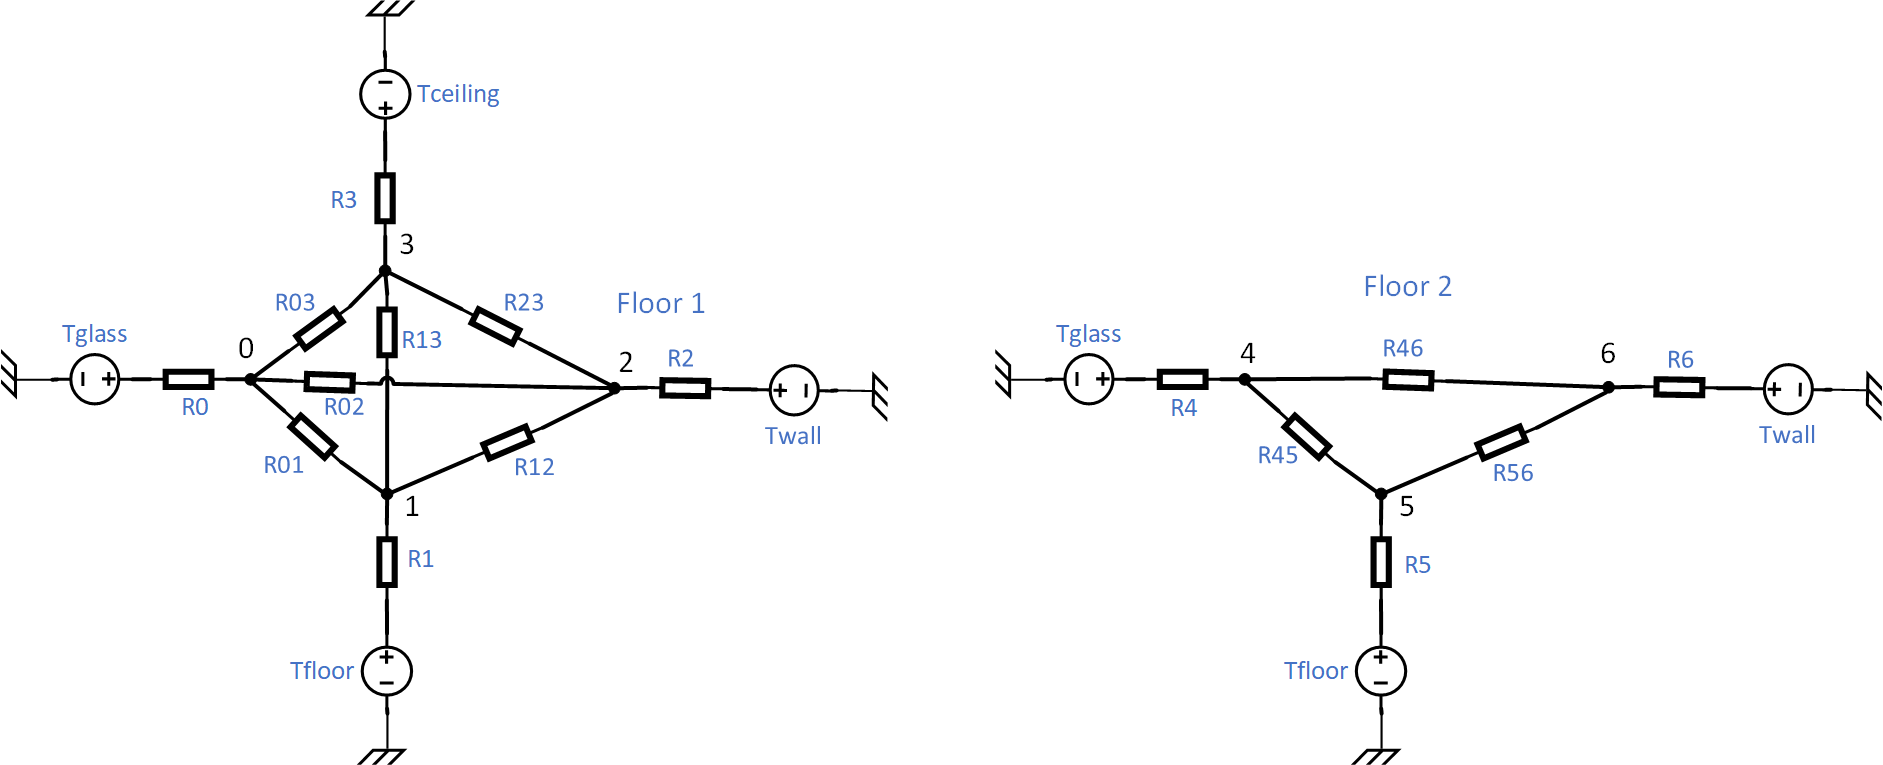
> Figure 4. Radiative long-wave heat exchange between the surfaces for each floor. The branches from one source to another are showing the resistance placed in Figure 3.

For two surfaces, shown by the example between the floor and the wall of floor 1, the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy), in m², for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, the [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)), and the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

where:
- $\varepsilon_1$ and $\varepsilon_2$ are the [emmisivities](https://en.m.wikipedia.org/wiki/Emissivity) of the surfaces 1 and 2;
- $S_1$ and $S_2$ - areas of the surfaces 1 and 2, m²;
- $F_{1,2}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surfaces 1 and 2.

For further calculations the mean temperature $\bar{T}$, measured in kelvin, is used:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).

In [12]:
Tm = 20 + 273   # K, mean temp for radiative exchange

After the linearization of the equations shown above, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

The equivalent resistance, in W/K, for the radiative long-wave heat exchange between the different surfaces (here; floor and wall of floor 1):
$$R = 1/G_1 + 1/G_{1,2} + 1/G_2$$

In [13]:
# glass view
# glass and floor
GLWF1 = 4 * σ * Tm**3 * ε_wLWf / (1 - ε_wLWf) * Sg
GLWF10 = 4 * σ * Tm**3 * F[0, 1] * Sg
GLWF0 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
RLWGF = (1 / GLWF1 + 1 / GLWF10 + 1 / GLWF0)

# glass and ceiling
GLWC3 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * Sg
GLWC30 = 4 * σ * Tm**3 * F[0, 3] * Sg
GLWC0 = GLWF0
RLWGC = (1 / GLWC3 + 1 / GLWC30 + 1 / GLWC0)

# glass and Wall/ wall and glass
GLW2 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * Sg
GLW20 = 4 * σ * Tm**3 * F[0, 2] * Sg
GLW0 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Glass']
RLWGW = (1 / GLW2 + 1 / GLW20 + 1 / GLW0)

# Wall view
# wall and floor
GLWF12 = 4 * σ * Tm**3 * F[2, 1] * Sg
GLWF2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * (Sw1 + Sw2)
RLWWF = (1 / GLWF1 + 1 / GLWF12 + 1 / GLWF2)

# wall and ceiling
GLWC32 = 4 * σ * Tm**3 * F[2, 3] * Sg
GLWC2 = GLWF2
RLWWC = (1 / GLWC3 + 1 / GLWC32 + 1 / GLWC2)

# floor view - ceiling view
# floor and ceiling
GLW31 = 4 * σ * Tm**3 * F[0, 2] * Sg
RLWFC = (1 / GLWC3 + 1 / GLW31 + 1 / GLWF1)

### Advection

The [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate) of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  ([air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour)) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [14]:
# implementing he advection part
Va = V1                     # m³ volume of air
ACH = 1                    # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s air infiltration

# ventilation & advection
Rv = air['Density'] * air['Specific heat'] * Va_dot

The net flow rate that the building receives by [advection](https://en.m.wikipedia.org/wiki/Advection), i.e., introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [air infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

where:
- $\dot{m}_a$ is the [mass flow rate](https://en.m.wikipedia.org/wiki/Mass_flow_rate) of air, kg/s;
- $\dot{V}_a$ - [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate), m³/s;
- $c_a$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the air, J/kg·K;
- $\rho_a$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $T_o$ - outdoor air temperature, °C (noted in majuscule because it is a *temperature source* or *input variable*);
- $\theta_i$ - indoor air temperature, °C (noted in minuscule because it is a *dependent temperature* or *output variable*).

Therefore, the conductance of [advection](https://en.m.wikipedia.org/wiki/Advection) by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

### Defining the controller for the HVAC system
For this simulation the HVAC system is considered to be a propotial controller that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperatures $\theta_{i1}$ and $\theta_{i2}$ at its setpoint value $T_{i,sp1}$ and $T_{i,sp2}$.
The heat flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C (noted in majuscule because it is an *input, i.e. independent, variable*);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is a *output, i.e. dependent variable*).

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends to:
- infinity, $K_p \rightarrow \infty$, then the control is perfect, $\theta_i \rightarrow T_{i, sp}$.
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from the lower to the higher potential of the temperature source $T_{i,sp}$.


In [15]:
# controller gain
Kp = 0 #for the steady state conditions
#Kp = 2000 #for the dynamic simulation

### Defining the resistance for the glass window
The resistance for the window is a series connection of different resistors, for the convection in the outdoor air (convection) and the conduction of the glass.
If resistances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the connection). Therefore, the resistance for the window front is composed as follows:


$$ R_{gs} = R_{g,cv.out} + (2 * R_{g,cd}) = h_{out} S_g + 2\frac{\lambda S_g}{w}
$$


In [16]:
# glass: convection outdoor & conduction
Rgs = float(Rg['out'] + (2 * R_cd['Glass']))

## Definition of the thermal capacities

## Definition of the capcities and the capacity matrix C
### Calculating the capacity for the wall, ground, floor and roof
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall,  ground, floor and roof, in J/kg, are of the form:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [17]:
# Capacities and Capacity Matrix
Cp = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [18]:
Cp['Air'] = air['Density'] * air['Specific heat'] * Va

# Defining the mathematical model

In the following section, the thermal model is converted into the mathematical notation and a system of algebraic differential equations is created. For this purpose, the system matrices and vectors consisting of the incidence matrix A, the conductivity matrix G, the capacitance matrix C, the source vector b, the flux vector f and the solution vector y must be defined.
## Defining the system of algebraic-differential equations (DAE)

### Definition of the incidence matrix A

The incidence matrix A is a matrix with the size of the number of flows times nodes (in this model 39x22). The heat flow is shown on each line and the temperature node is shown in each column. If a branch now leaves a certain temperature node, then a "-1" is written at this point, but if a branch arrives at a node, then a "1" is written at the relevant position.

In [19]:
A = np.zeros([brn, nds])
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 3], A[5, 5] = -1, 1    # branch 5: node 3 -> node 5
A[6, 4], A[6, 5] = -1, 1    # branch 6: node 4 -> node 5
A[7, 6] = 1                 # branch 7: -> node 6
A[8, 6], A[8, 4] = -1, 1    # branch 8: node 6 -> node 4
A[9, 7] = 1                 # branch 9: -> node 7
A[10, 7], A[10, 8] = -1, 1  # branch 10: node 7 -> node 8
A[11, 8], A[11, 9] = -1, 1  # branch 11: node 8 -> node 10
A[12, 9], A[12, 10] = -1, 1  # branch 12: node 10 -> node 11
A[13, 10], A[13, 11] = -1, 1  # branch 13: node 11 -> node 12
A[14, 3], A[14, 11] = -1, 1   # branch 14: node 3 -> node 11
A[15, 4], A[15, 11] = -1, 1   # branch 15: node 4 -> node 11
A[16, 11], A[16, 5] = -1, 1   # branch 16: node 11 -> node 5
A[17, 5] = 1                  # branch 17: -> node 5
A[18, 5] = 1                  # branch 18: -> node 5
A[19, 5], A[19, 12] = -1, 1   # branch 19: node 5 -> node 12
A[20, 12], A[20, 13] = -1, 1    # branch 20: node 12 -> node 13
A[21, 13], A[21, 21] = -1, 1    # branch 21: node 13 -> node 21
A[22, 14] = 1                   # branch 22: -> node 14
A[23, 14], A[23, 15] = -1, 1    # branch 23: node 14 -> node 15
A[24, 15], A[24, 16] = -1, 1    # branch 24: node 15 -> node 16
A[25, 16], A[25, 17] = -1, 1    # branch 25: node 16 -> node 17
A[26, 17], A[26, 19] = -1, 1    # branch 26: node 17 -> node 19
A[27, 17], A[27, 18] = -1, 1    # branch 27: node 17 -> node 18
A[28, 18], A[28, 19] = -1, 1    # branch 28: node 18 -> node 19
A[29, 20] = 1                   # branch 29: -> node 20
A[30, 20], A[30, 18] = -1, 1    # branch 30: node 20 -> node 18
A[31, 19] = 1                   # branch 31: -> node 19
A[32, 19] = 1                   # branch 32: -> node 19
A[33, 21], A[33, 19] = -1, 1    # branch 33: node 21 -> node 19
A[34, 17], A[34, 21] = -1, 1    # branch 34: node 17 -> node 21
A[35, 18], A[35, 21] = -1, 1    # branch 35: node 18 -> node 21
A[36, 12], A[36, 3] = -1, 1     # branch 36: node 12 -> node 3
A[37, 12], A[37, 4] = -1, 1     # branch 37: node 12 -> node 4
A[38, 12], A[38, 11] = -1, 1    # branch 38: node 12 -> node 11
np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Setting up the matrix G

The conductivity matrix G has a quadratic (in this model branches times branches, 39x39) and diagonal shape, with all the conductivities of the individual branches on the diagonal. In this model, however, the resistance matrix R is created first, and the G can then be calculated using the reciprocal value.

In [20]:
R = np.zeros(brn)
R[0] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out']
R[1] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'])
R[2] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                R_cd['Concrete1'] + R_cd['Concrete2'])
R[3] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'])
R[4] = RLWGW
R[5] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in']
R[6] = Rg.iloc[0]['in']
R[7] = Rgs
R[8] = 1 / 2 * R_cd['Glass']
R[9] = 1 / 2 * R_cd['ground']
R[10] = 1 / 4 * R_cd['ground']
R[11] = 1 / 4 * R_cd['ground']
R[12] = 1 / 2 * R_cd['ground'] + 2 * R_cd['Concrete_ground']
R[13] = 1 / 2 * R_cd['Concrete_ground']
R[14] = RLWWF
R[15] = RLWGF
R[16] = Rgr
R[17] = 1
R[18] = Rv
R[19] = Rmid1
R[20] = 1 / 2 * R_cd['Concrete_mid']
R[21] = 1 / 2 * R_cd['Concrete_mid']
R[22] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out'] + Rroof.iloc[0]['out']
R[23] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'])
R[24] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'] + R_cd['Concrete1'] +
                 R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[25] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[26] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in'] + Rroof.iloc[0]['in']
R[27] = RLWGW
R[28] = Rg.iloc[0]['in']
R[29] = Rgs
R[30] = 1 / 2 * R_cd['Glass']
R[31] = Rv
R[32] = 1
R[33] = Rmid2
R[34] = RLWWF
R[35] = RLWGF
R[36] = RLWWC
R[37] = RLWGC
R[38] = RLWFC
G = np.diag(np.reciprocal(R))
G[17, 17] = Kp
G[32, 32] = Kp
pd.set_option("display.precision", 3)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,250.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
1,0.0,7.5,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
2,0.0,0.0,7.119,0.0,0.000,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
3,0.0,0.0,0.000,140.0,0.000,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
4,0.0,0.0,0.000,0.0,138.547,0.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
5,0.0,0.0,0.000,0.0,0.000,80.0,0.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
6,0.0,0.0,0.000,0.0,0.000,0.0,100.0,0.000,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
7,0.0,0.0,0.000,0.0,0.000,0.0,0.0,273.438,0.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
8,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,8750.0,0.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000
9,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,150.0,...,0.000,0.0,0.000,0.0,0.0,0.000,0.00,0.000,0.000,0.000


### Setting up the capacity matrix C

The capacitance matrix C is a nodes times nodes matrix and includes all the capacities of the thermal model shown in Figure 3. It has the shape of diagonal matrix and if there is no capacity at a certain node, there will not be a capacitance. For certain nodes there are different wall surfaces, so the individual walls are added up so that they are considered as one large surface.

In [21]:
C = np.zeros(nds)
C[1] = Cp['Insulation1'] + Cp['Insulation2']
C[2] = Cp['Concrete1'] + Cp['Concrete2']
C[5] = Cp['Air']
C[7] = Cp['ground']
C[8] = Cp['ground']
C[9] = Cp['ground']
C[10] = Cp['Concrete_ground']
C[13] = Cp['Concrete_mid']
C[15] = Cp['Insulation1'] + Cp['Insulation2'] + Cp['Insulation_roof']
C[16] = Cp['Concrete1'] + Cp['Concrete2'] + Cp['Concrete_roof']
C[19] = Cp['Air']
C = np.diag(C)
pd.set_option("display.precision", 3)
pd.DataFrame(C)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
1,0.0,332750.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.500e+07,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000e+00,0.0,0.0,150000.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,1.000e+08,0.000e+00,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,1.000e+08,0.000e+00,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.000e+00,0.000e+00,1.000e+08,...,0.0,0.000e+00,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0


### Definition of the source vector b
The vector of *temperature sources* is $b$, of size $brn$, the number of branches (in this example 39). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative. 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &T_o  &0  &T_G &0  &0  &0  &0  &0  &0 &0  &T_{i,sp1} &T_o  &0 &0  &0  &To &0 &0  &0 &0 &0  &0 &T_o &0  &T_0  &T_{i,sp2} 
\end{matrix}]^T$$

i.e. $b_0 = b_7 = b_{18} = b_{22} = b_{29} = b_{31} = T_o$, 
$b_{9} = T_{G}$, $b_{17} = T_{i,sp1}$ and $b_{32} = T_{i,sp2}$where:
- $T_o$ is the outdoor temperature, °C;
- $T_G$ is the ground temperature, °C;
- $T_{i,sp1}, T_{i,sp2}$ - set-point temperaure for the indoor air on the floors 1 and 2, °C.

Since all of the temperature sources are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temperature source by $0$.

In [22]:
b = np.zeros(brn)       # size defined by branches
b[[0, 7, 9, 17, 18, 22, 29, 31, 32]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]


### Definition of the heat flow source vector f

The vector of *heat sources* is $f$, of size $nds$, the number of nodes (in this model 22). An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &\Phi_i  &0  &0  &\Phi_a &0 &0  &0  &0 &0  &0  &0 &\Phi_o  &0  &0 &\Phi_i  &0  &0 &\Phi_a  &0  &0
\end{matrix}]^T$$

i.e. $f_0 = f_14 = \Phi_o$, $f_3 = f_17 = \Phi_i$, and $f_6 = f_20 = \Phi_a$, where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the building, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the rooms, W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

Since the flow rate sorces $\Phi_o$, $\Phi_i$ and $\Phi_a$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [23]:
f = np.zeros(nds)         # size defined by nodes
f[[0, 3, 6, 14, 17, 20]] = 1       # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]


### Output vector y

The vector of outputs is $y$, of size $nds$, the number of nodes (in this model 22). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in Figure 3, if the output is the indoor air temperatures, then the output vector is:

$$y = [\begin{matrix}
0 &0  &0  &0  &0  &\theta_5  &0  &0  &0  &0  &0  &0 &0  &0  &0  &0  &0  &0  &0  &\theta_{19}  &0  &0  &0 
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [24]:
y = np.zeros(nds)       # size defined by nodes
y[[5, 19]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## State-Space representation of the system
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

For this step, there is a function that does the conversion. For this, the library "dm4bem" and the command "tc2ss" are needed. The system matrices for are as follows:

In [25]:
# State Space representation for the DAE
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
pd.set_option("display.precision", 3)
print('As = \n', pd.DataFrame(As), '\n')
print('Bs = \n', pd.DataFrame(Bs), '\n')
print('Cs = \n', pd.DataFrame(Cs), '\n')
print('Ds = \n', pd.DataFrame(Ds), '\n')

As = 
            0          1          2          3          4          5   \
0  -4.328e-05  2.139e-05  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
1   2.847e-07 -3.665e-06  2.003e-06  0.000e+00  0.000e+00  0.000e+00   
2   0.000e+00  3.338e-04 -3.394e-03  0.000e+00  0.000e+00  0.000e+00   
3   0.000e+00  0.000e+00  0.000e+00 -4.500e-06  3.000e-06  0.000e+00   
4   0.000e+00  0.000e+00  0.000e+00  3.000e-06 -6.000e-06  3.000e-06   
5   0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.000e-06 -3.477e-06   
6   0.000e+00  6.192e-08  3.101e-06  0.000e+00  0.000e+00  9.545e-07   
7   0.000e+00  1.468e-07  7.366e-06  0.000e+00  0.000e+00  0.000e+00   
8   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
9   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   
10  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00   

           6          7          8          9          10  
0   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  
1   1.23

## Steady-state formulation

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor and ground temperature is $T_o = T_G = 10 \, \mathrm{^\circ C}$,
- the indoor temperature of floor 1 setpoint is $T_{i,sp1} = 20 \, \mathrm{^\circ C}$,
- the indoor temperature of floor 2 setpoint is $T_{i,sp2} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

If the solutions of the systems of DAE are 10°C it shows that this model is not wrong.

In [26]:
# Steady State formulation
b = np.zeros(brn)                  # temperature sources
b[[0, 7, 9, 18, 22, 29, 31]] = 10  # outdoor temperature and ground temperature
b[[17, 32]] = 20                   # indoor set-point temperature

f = np.zeros(nds)         # flow-rate sources
print(f'b = ', b)
print(f'f = ', f)

b =  [10.  0.  0.  0.  0.  0.  0. 10.  0. 10.  0.  0.  0.  0.  0.  0.  0. 20.
 10.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0. 10.  0. 10. 20.  0.  0.  0.
  0.  0.  0.]
f =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering $\dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_{22}$, including the indoor air temperature $\theta_5$ and $\theta_{19}$, are equal to $T_o = 10 \, \mathrm{^\circ C}$.

In [27]:
# System of Diferential Algebraic Equations (DAE)
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.] °C


### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For the circuit presented in Figure 3, $b_T = [T_o, T_o, T_G, T_{i,sp1}, To, To, To, To, T_{i,sp2}]^T$ corresponding to branches 0, 7, 9, 17, 18, 22, 29, 31 and 32.

- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \Phi_a, \Phi_o, \Phi_i, \Phi_a]^T$ corresponding to nodes 0, 3, 6, 14, 17, and 20.

*Note*: zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [28]:
# State Space representation of u
bT = np.array([10, 10, 10, 20, 10, 10, 10, 10, 20])  # [To, To, TG, Tisp1, To, To, To, To, Tisp2]
fQ = np.array([0, 0, 0, 0, 0, 0])                    # [Φo, Φi, Φa, Φo, Φi, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 20 10 10 10 10 20  0  0  0  0  0  0]


The steady-state value of the output of the state-space representation is:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [29]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')
print(f'Max error between DAE and state-space: \ {max(abs(θ[6] - yss)):.2e} °C')

yss = [10. 10.] °C
Max error between DAE and state-space: \ 3.02e-14 °C


# Buildig the step response and the dynamic simulation in Python environment

The following section shows how to implement the Step Response and Dynamic Simulation in Python. Weather data from the Zurich Affoltern measuring station is used for this purpose.

## Time step
The first step is to define the simulation time step. This should be as small as necessary but as large as the model allows. If it is too large, the model may be numerically unstable and cause oscillations in the calculation.
The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [30]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')
dt = 2 * 60     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

Time constants: 
 [2.94218543e+02 4.51193547e+02 2.30261528e+04 4.97360235e+04
 1.99202667e+06 7.34265435e+05 4.48358620e+05 2.69671167e+05
 2.34614173e+05 1.03957352e+05 1.07073944e+05] s 

2 x Time constants: 
 [5.88437085e+02 9.02387095e+02 4.60523057e+04 9.94720470e+04
 3.98405333e+06 1.46853087e+06 8.96717241e+05 5.39342335e+05
 4.69228346e+05 2.07914704e+05 2.14147888e+05] s 

Maximum time step: 588.44 s = 9.81 min
dt = 120 s = 2 min


## Settling time

The settling time determines how long the model needs to react to a change in the input and adjust the output value accordingly. It is important to consider the stepresponse for this long and to plan this time as a lead time for the simulation.

In [31]:
# Settling Time
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [2.94218543e+02 4.51193547e+02 2.30261528e+04 4.97360235e+04
 1.99202667e+06 7.34265435e+05 4.48358620e+05 2.69671167e+05
 2.34614173e+05 1.03957352e+05 1.07073944e+05] s 

Settling time: 7968107 s = 132801.8 min = 2213.36 h = 92.22 days


## Building up a step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [32]:
duration = 3600 * 24 * 93            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')

Duration = 8035200 s
Number of time steps = 66960


### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is again obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

For dynamic simulation, each element in u consists of a time series, so the values can vary over time.

Let's consider in a first simulation a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_G = 10 \, \mathrm{^\circ C}$, $T_{i,sp1} = T_{i,sp2} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [33]:
# Input Vector definition for the Step response
u = np.zeros([len(bT) + len(fQ), n])         # [To, To, TG, Tisp1, To, To, To, To, Tisp2, Φo, Φi, Φa, Φo, Φi, Φa]
u[[[0, 1, 4, 5, 6, 7]], :] = 10 * np.ones([6, n])    # To = 10 for n time steps
u[2, :] = 10 * np.ones([1, n])    # TG = 12 for n time steps
u[[3, 8], :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,66950,66951,66952,66953,66954,66955,66956,66957,66958,66959
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
6,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
7,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
8,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating the step response with Euler explicit and implicit
By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [34]:
n_s = As.shape[0]                      # number of state variables
θ_expsr = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_impsr = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

In [35]:
for k in range(n - 1):
    θ_expsr[:, k + 1] = (I + dt * As) @\
        θ_expsr[:, k] + dt * Bs @ u[:, k]
    θ_impsr[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_impsr[:, k] + dt * Bs @ u[:, k])

Following output were calculated and shown in the variables $y_{exp}$ and $y_{imp}$:

In [36]:
y_expsr = Cs @ θ_expsr + Ds @  u
y_impsr = Cs @ θ_impsr + Ds @  u

## Dynamic Simulation with weather data of Zurich Affoltern
First, the weather data must be read in from an ".epw" file. In these files, the months are taken from different years and put together to form a year with weather data. Since the settling time is more than 2 months, it makes sense to simulate for at least 3 - 4 months and then analyse the last one. So that the different year numbers do not pose a problem, they are all set to a uniform number.
From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.
The ground temperature is assumed to be constant at 3 meters depth and is set at 10°C.

In [37]:
start_date = '2000-01-01 12:00:00'
end_date = '2000-06-01 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = './weather_data/CHE_ZH_Zurich.Affoltern.066640_TMYx.2007-2021.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

2000-01-01 12:00:00 	start date
2000-06-01 18:00:00 	end date


### Solar irradiance on the walls
After that, the irradiation of the weather data must be converted to my building areas. For this, it is assumed that all walls are vertical and the roof represents a horizontal surface. The total irradiation is made up of a direct, reflected and diffuse portion of the light.

For the surface orientation given by `slope`, `azimuth`and `latitude`, using the weather data, we may calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.


In [38]:
surface_orientation = {'slope': 90,
                        'azimuth': 0,
                        'latitude': 47}

surface_orientation2 = {'slope': 0,
                        'azimuth': 0,
                        'latitude': 47}
albedo = 0.2
rad_surf_W = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)  # Wall
rad_surf_R = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation2, albedo)  # Roof

rad_surf_W['EtotWall'] = rad_surf_W.sum(axis=1)
rad_surf_R['Etot'] = rad_surf_R.sum(axis=1)


### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [39]:
data = pd.concat([weather['temp_air'], rad_surf_W['EtotWall'],
                  rad_surf_R['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
print('data = ')
pd.DataFrame(data)

data = 


,To,EtotWall,Etot
2000-01-01 12:00:00+01:00,1.900,584.997,271.304
2000-01-01 12:02:00+01:00,1.897,583.839,269.790
2000-01-01 12:04:00+01:00,1.893,582.680,268.277
2000-01-01 12:06:00+01:00,1.890,581.521,266.763
2000-01-01 12:08:00+01:00,1.887,580.362,265.249
...,...,...,...
2000-06-01 16:52:00+01:00,22.027,70.067,168.121
2000-06-01 16:54:00+01:00,22.020,68.864,164.250
2000-06-01 16:56:00+01:00,22.013,67.660,160.380
2000-06-01 16:58:00+01:00,22.007,66.456,156.510


### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp1} = 21 \, \mathrm{^\circ C}$, $T_{i,sp2} = 20 \, \mathrm{^\circ C}$ and the ground temperature $T_G = 10 \,  \mathrm{^\circ C}$ constant for the whole duration of the simulation.

In [40]:
# Input conditions
data['Ti1'] = 21 * np.ones(data.shape[0])
data['Ti2'] = 21 * np.ones(data.shape[0])
data['TG'] = 10 * np.ones(data.shape[0])

### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [T_o, T_o, T_G, T_{i,sp1}, To, To, To, To, T_{i,sp2} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \Phi_a, \Phi_o, \Phi_i, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_G\\ 
T_{i,sp1}\\ 
T_o\\ 
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp2}\\
\Phi_o\\ 
\Phi_i\\ 
\Phi_a\\
\Phi_o\\ 
\Phi_i\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{G(0)} & T_{G(1)}& ... & T_{G(n-1)}\ \\ 
 T_{i,sp1(0)} & T_{i,sp1(1)}& ... & T_{i,sp1(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp2(0)} & T_{i,sp1(1)}& ... & T_{i,sp1(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}\\
 \Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$


$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall or roof:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall, roof in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall or roof, m²;
- $E_{tot}$ - total solar irradiation on the wall or roof, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall or roof:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;


In [41]:
To = data['To']
Ti1 = data['Ti1']
Ti2 = data['Ti2']
TG = data['TG']
Φo1 = α_wSW * (Sw1 + Sw2) * data['EtotWall']
Φo2 = α_wSW * Sg * data['Etot'] + Φo1
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['EtotWall']
Φa = α_gSW * wall['Surface']['Glass'] * data['EtotWall']

In [42]:
u = pd.concat([To, To, TG, Ti1, To, To, To, To, Ti2, Φo1, Φi, Φa, Φo2, Φi, Φa],
              axis=1)
u.columns.values[[9, 10, 11, 12, 13, 14]] = ['Φo1', 'Φi', 'Φa', 'Φo2', 'Φi', 'Φa']
print('u = ')
pd.DataFrame(u)

u = 


,To,To,TG,Ti1,To,To,To,To,Ti2,Φo1,Φi,Φa,Φo2,Φi,Φa
2000-01-01 12:00:00+01:00,1.900,1.900,10.0,21.0,1.900,1.900,1.900,1.900,21.0,9140.586,548.435,2778.738,12531.882,548.435,2778.738
2000-01-01 12:02:00+01:00,1.897,1.897,10.0,21.0,1.897,1.897,1.897,1.897,21.0,9122.479,547.349,2773.234,12494.856,547.349,2773.234
2000-01-01 12:04:00+01:00,1.893,1.893,10.0,21.0,1.893,1.893,1.893,1.893,21.0,9104.372,546.262,2767.729,12457.829,546.262,2767.729
2000-01-01 12:06:00+01:00,1.890,1.890,10.0,21.0,1.890,1.890,1.890,1.890,21.0,9086.266,545.176,2762.225,12420.802,545.176,2762.225
2000-01-01 12:08:00+01:00,1.887,1.887,10.0,21.0,1.887,1.887,1.887,1.887,21.0,9068.159,544.090,2756.720,12383.776,544.090,2756.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-06-01 16:52:00+01:00,22.027,22.027,10.0,21.0,22.027,22.027,22.027,22.027,21.0,1094.804,65.688,332.820,3196.314,65.688,332.820
2000-06-01 16:54:00+01:00,22.020,22.020,10.0,21.0,22.020,22.020,22.020,22.020,21.0,1075.996,64.560,327.103,3129.127,64.560,327.103
2000-06-01 16:56:00+01:00,22.013,22.013,10.0,21.0,22.013,22.013,22.013,22.013,21.0,1057.188,63.431,321.385,3061.939,63.431,321.385
2000-06-01 16:58:00+01:00,22.007,22.007,10.0,21.0,22.007,22.007,22.007,22.007,21.0,1038.380,62.303,315.668,2994.752,62.303,315.668


### Initial conditions
The initial value of the state-vector can be zero or different from zero. After the settling time the model is nomore depending on this value and is for each initial value the same.

In [43]:
# Initial Conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
θ_imp = 20 * np.ones([As.shape[0], u.shape[0]])    # implicit Euler in time t

### Time integration of the model
The last step is to carry out the simulation. Here the Euler method is used again. If the explicit method is chosen, the simulation can be carried out more quickly; with the implicit method it takes longer, but it is numerically more stable.

In [44]:
choose_Euler = 1

If the variable "choose_Euler" is 1 the explicit-, if it is 0 the implicit method is chosen.

In [45]:
if choose_Euler == 1:
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u.iloc[k, :]

    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_exp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_exp[0, :])
elif choose_Euler == 0:
    for k in range(u.shape[0] - 1):
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k] + dt * Bs @ u.iloc[k, :])
    
    y_imp = Cs @ θ_imp + Ds @  u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_imp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_imp[0, :])

# Simulation results

The following section presents the results of the simulation of the model. These include the step response and several different dynamic simulations with the real weather data.

## Step response results


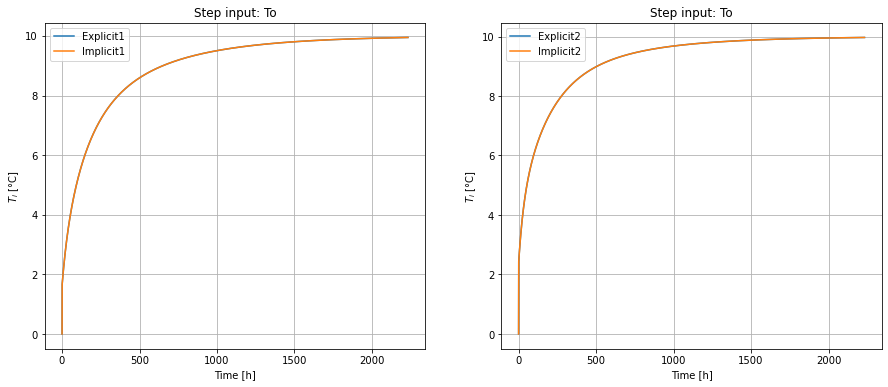

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 6))
ax1.plot(t / 3600, y_expsr.T[:,0], t / 3600, y_impsr.T[:,0])
ax1.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax1.legend(['Explicit1', 'Implicit1' ])
ax1.grid('true')
ax2.plot(t / 3600, y_expsr.T[:,1], t / 3600, y_impsr.T[:,1])
ax2.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax2.legend(['Explicit2', 'Implicit2' ])
ax2.grid('true')
plt.show()

>Figure 5: On the left graph the step respons for floor 1 and in the rigth the one for the floor 2 is shown.

Figure 5 shows the step response of the model in free run mode. Around 1500 to 2000 hours are needed to reach the input temperature. This example also shows that both simulation methods are almost the same and differ only very little. Thus, the Euler Explicit method can also be used for the selected settings.

## Dynamic simulation results

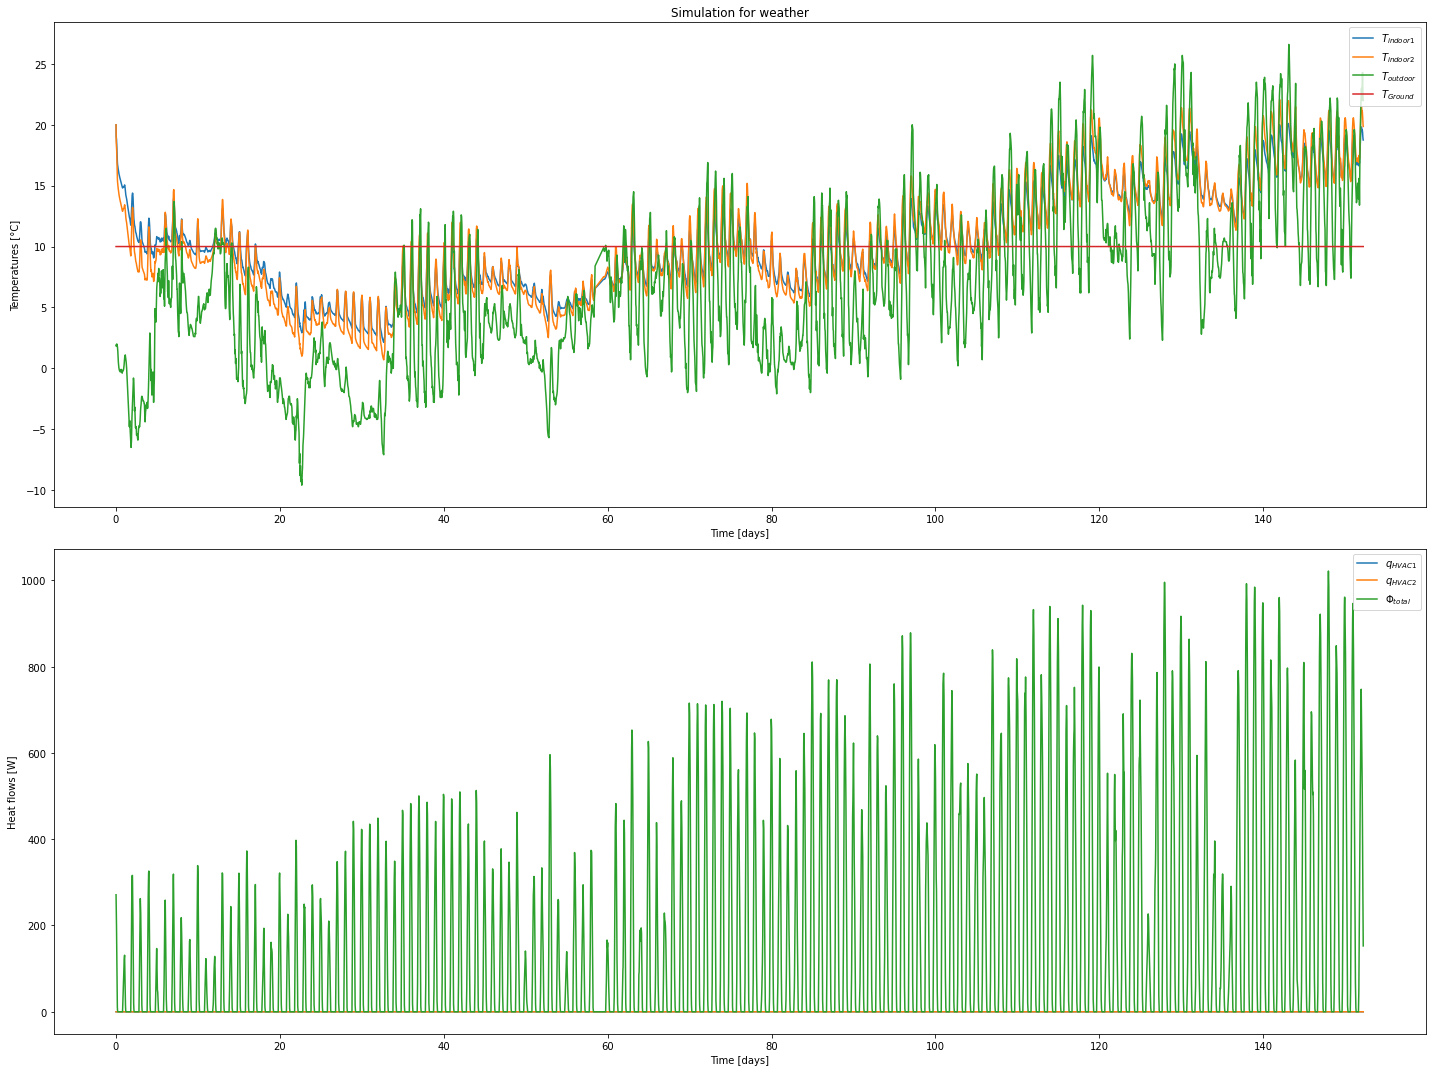

In [47]:
t = dt * np.arange(data.shape[0])   # time vector
fig, axs = plt.subplots(2, 1,figsize=(20, 15))
if choose_Euler == 1:
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_exp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
elif choose_Euler == 0:
        # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_imp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_imp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, q_HVAC1, label='$q_{HVAC1}$')
axs[1].plot(t / 3600 / 24, q_HVAC2, label='$q_{HVAC2}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 6. Simulation with building in free running using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

Figure 6 shows the dynamic simulation of the building in free running mode. The upper picture shows the temperatures inside and outside the building and the lower picture shows the heat fluxes from solar radiation or the HVAC system (which are switched off here). It can be seen that the temperature can be influenced by solar radiation and warms the interior. Without a heating system, however, you would quickly lose the heat again in cold temperatures.


### Higher value of Kp

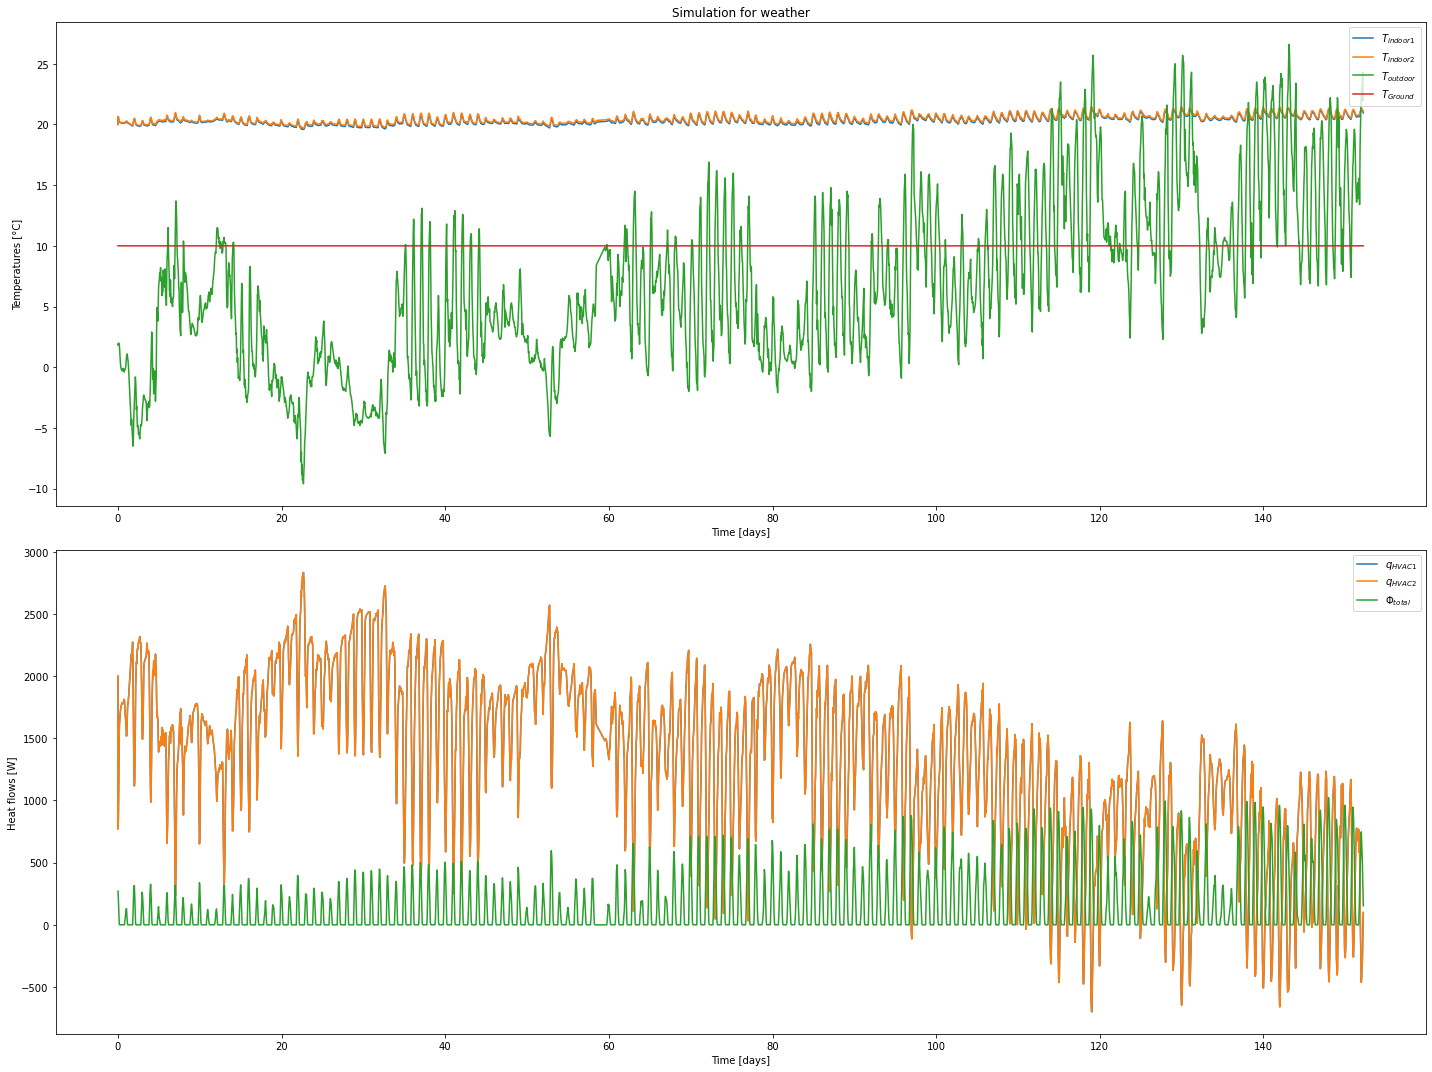

In [48]:
dt = 1*60
Kp = 2000
choose_Euler = 1
θ_imp = 20 * np.ones([As.shape[0], u.shape[0]])    # implicit Euler in time t

#Conductance Matrix G
# number of temperature nodes and flow branches
R = np.zeros(brn)
R[0] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out']
R[1] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'])
R[2] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                R_cd['Concrete1'] + R_cd['Concrete2'])
R[3] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'])
R[4] = RLWGW
R[5] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in']
R[6] = Rg.iloc[0]['in']
R[7] = Rgs
R[8] = 1 / 2 * R_cd['Glass']
R[9] = 1 / 2 * R_cd['ground']
R[10] = 1 / 4 * R_cd['ground']
R[11] = 1 / 4 * R_cd['ground']
R[12] = 1 / 2 * R_cd['ground'] + 2 * R_cd['Concrete_ground']
R[13] = 1 / 2 * R_cd['Concrete_ground']
R[14] = RLWWF
R[15] = RLWGF
R[16] = Rgr
R[17] = 1
R[18] = Rv
R[19] = Rmid1
R[20] = 1 / 2 * R_cd['Concrete_mid']
R[21] = 1 / 2 * R_cd['Concrete_mid']
R[22] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out'] + Rroof.iloc[0]['out']
R[23] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'])
R[24] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'] + R_cd['Concrete1'] +
                 R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[25] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[26] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in'] + Rroof.iloc[0]['in']
R[27] = RLWGW
R[28] = Rg.iloc[0]['in']
R[29] = Rgs
R[30] = 1 / 2 * R_cd['Glass']
R[31] = Rv
R[32] = 1
R[33] = Rmid2
R[34] = RLWWF
R[35] = RLWGF
R[36] = RLWWC
R[37] = RLWGC
R[38] = RLWFC
G = np.diag(np.reciprocal(R))
G[17, 17] = Kp
G[32, 32] = Kp
# Temperature Source Vector b
b = np.zeros(brn)       # size defined by branches
b[[0, 7, 9, 17, 18, 22, 29, 31, 32]] = 1   # branches with temperature sources

# Heat flow source Vector f
f = np.zeros(nds)         # size defined by nodes
f[[0, 3, 6, 14, 17, 20]] = 1       # nodes with heat-flow sources

# Output Vector y
y = np.zeros(nds)       # size defined by nodes
y[[5, 19]] = 1              # nodes (temperatures) of interest


# State Space representation for the DAE
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Input conditions
data['Ti1'] = 21 * np.ones(data.shape[0])
data['Ti2'] = 21 * np.ones(data.shape[0])
data['TG'] = 10 * np.ones(data.shape[0])
To = data['To']
Ti1 = data['Ti1']
Ti2 = data['Ti2']
TG = data['TG']
Φo1 = α_wSW * (Sw1 + Sw2) * data['EtotWall']
Φo2 = α_wSW * Sg * data['Etot'] + Φo1
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['EtotWall']
Φa = α_gSW * wall['Surface']['Glass'] * data['EtotWall']
u = pd.concat([To, To, TG, Ti1, To, To, To, To, Ti2, Φo1, Φi, Φa, Φo2, Φi, Φa],
              axis=1)
u.columns.values[[9, 10, 11, 12, 13, 14]] = ['Φo1', 'Φi', 'Φa', 'Φo2', 'Φi', 'Φa']

# Initial Conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
if choose_Euler == 1:
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u.iloc[k, :]

    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_exp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_exp[0, :])
elif choose_Euler == 0:
    for k in range(u.shape[0] - 1):
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k] + dt * Bs @ u.iloc[k, :])
    
    y_imp = Cs @ θ_imp + Ds @  u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_imp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_imp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector
    
fig, axs = plt.subplots(2, 1,figsize=(20, 15))
if choose_Euler == 1:
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_exp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
elif choose_Euler == 0:
        # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_imp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_imp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, q_HVAC1, label='$q_{HVAC1}$')
axs[1].plot(t / 3600 / 24, q_HVAC2, label='$q_{HVAC2}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 7: Simulation of the building with Kp = 1500.

In figure 7 you can now observe how the heating system tries to maintain the temperature in the two interior rooms. Since the same setpoint temperatures were set at the top and bottom, their temperature behaviour is the same. As soon as the indoor temperature is too warm, the HVAC system must switch to cooling mode. This results in the negative power peaks.

### Simulation with Euler implicit method

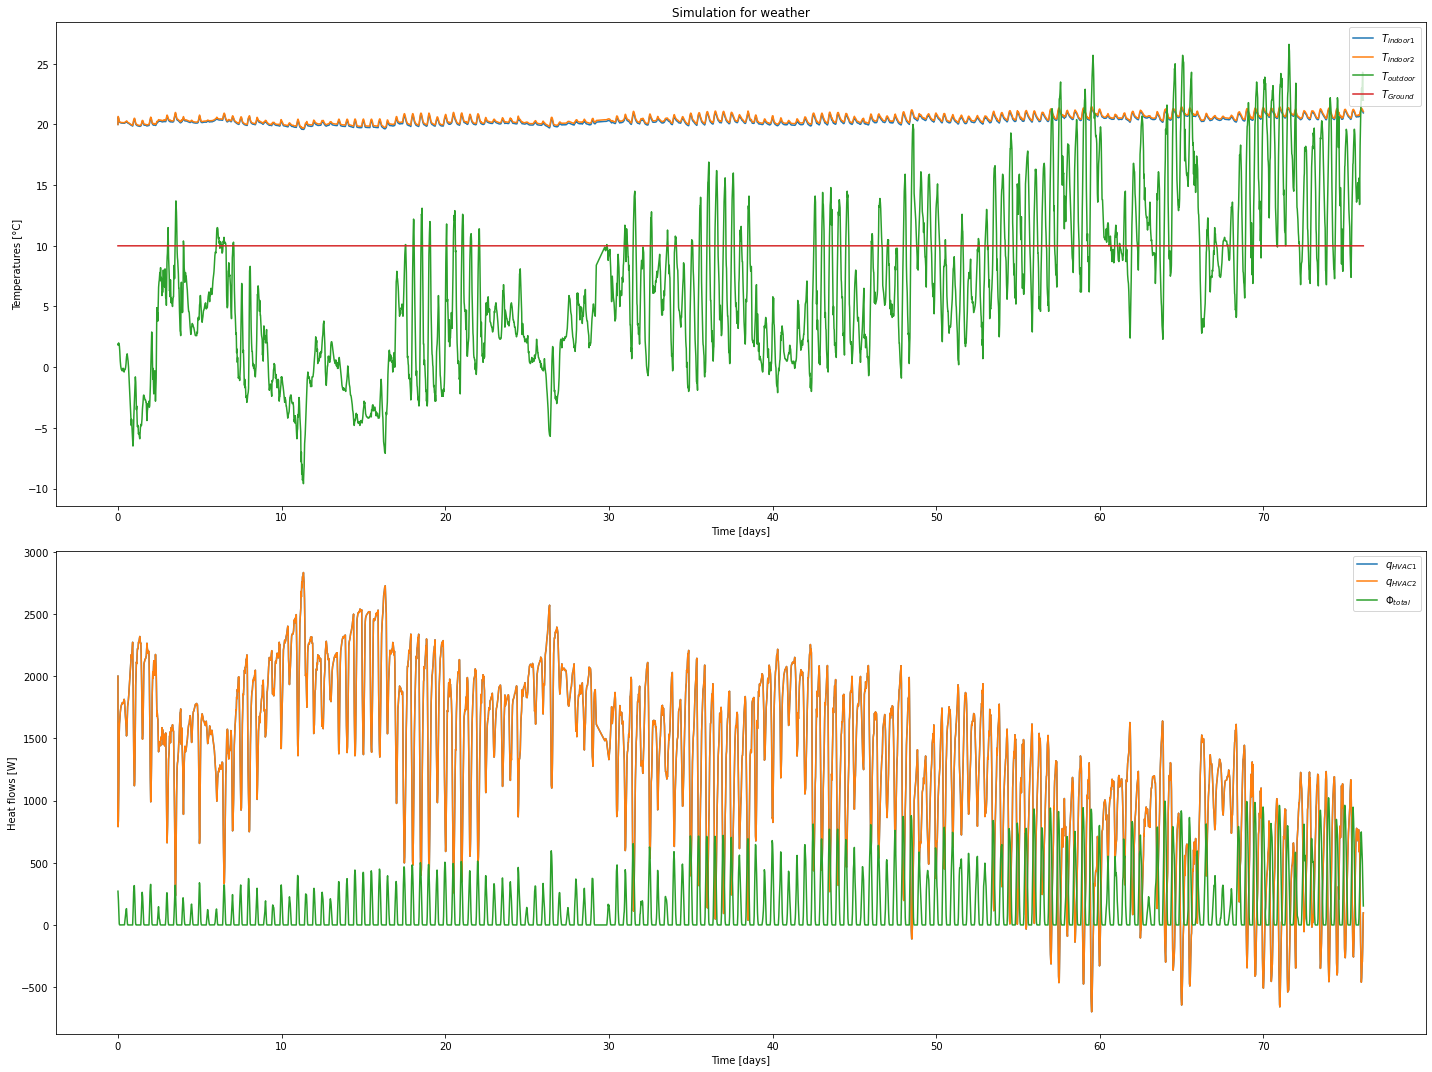

In [49]:
Kp = 2000
choose_Euler = 0
θ_imp = 20 * np.ones([As.shape[0], u.shape[0]])    # implicit Euler in time t

#Conductance Matrix G
# number of temperature nodes and flow branches
R = np.zeros(brn)
R[0] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out']
R[1] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'])
R[2] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                R_cd['Concrete1'] + R_cd['Concrete2'])
R[3] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'])
R[4] = RLWGW
R[5] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in']
R[6] = Rg.iloc[0]['in']
R[7] = Rgs
R[8] = 1 / 2 * R_cd['Glass']
R[9] = 1 / 2 * R_cd['ground']
R[10] = 1 / 4 * R_cd['ground']
R[11] = 1 / 4 * R_cd['ground']
R[12] = 1 / 2 * R_cd['ground'] + 2 * R_cd['Concrete_ground']
R[13] = 1 / 2 * R_cd['Concrete_ground']
R[14] = RLWWF
R[15] = RLWGF
R[16] = Rgr
R[17] = 1
R[18] = Rv
R[19] = Rmid1
R[20] = 1 / 2 * R_cd['Concrete_mid']
R[21] = 1 / 2 * R_cd['Concrete_mid']
R[22] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out'] + Rroof.iloc[0]['out']
R[23] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'])
R[24] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'] + R_cd['Concrete1'] +
                 R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[25] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[26] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in'] + Rroof.iloc[0]['in']
R[27] = RLWGW
R[28] = Rg.iloc[0]['in']
R[29] = Rgs
R[30] = 1 / 2 * R_cd['Glass']
R[31] = Rv
R[32] = 1
R[33] = Rmid2
R[34] = RLWWF
R[35] = RLWGF
R[36] = RLWWC
R[37] = RLWGC
R[38] = RLWFC
G = np.diag(np.reciprocal(R))
G[17, 17] = Kp
G[32, 32] = Kp
# Temperature Source Vector b
b = np.zeros(brn)       # size defined by branches
b[[0, 7, 9, 17, 18, 22, 29, 31, 32]] = 1   # branches with temperature sources

# Heat flow source Vector f
f = np.zeros(nds)         # size defined by nodes
f[[0, 3, 6, 14, 17, 20]] = 1       # nodes with heat-flow sources

# Output Vector y
y = np.zeros(nds)       # size defined by nodes
y[[5, 19]] = 1              # nodes (temperatures) of interest


# State Space representation for the DAE
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Input conditions
data['Ti1'] = 21 * np.ones(data.shape[0])
data['Ti2'] = 21 * np.ones(data.shape[0])
data['TG'] = 10 * np.ones(data.shape[0])
To = data['To']
Ti1 = data['Ti1']
Ti2 = data['Ti2']
TG = data['TG']
Φo1 = α_wSW * (Sw1 + Sw2) * data['EtotWall']
Φo2 = α_wSW * Sg * data['Etot'] + Φo1
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['EtotWall']
Φa = α_gSW * wall['Surface']['Glass'] * data['EtotWall']
u = pd.concat([To, To, TG, Ti1, To, To, To, To, Ti2, Φo1, Φi, Φa, Φo2, Φi, Φa],
              axis=1)
u.columns.values[[9, 10, 11, 12, 13, 14]] = ['Φo1', 'Φi', 'Φa', 'Φo2', 'Φi', 'Φa']

# Initial Conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
if choose_Euler == 1:
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u.iloc[k, :]

    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_exp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_exp[0, :])
elif choose_Euler == 0:
    for k in range(u.shape[0] - 1):
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k] + dt * Bs @ u.iloc[k, :])
    
    y_imp = Cs @ θ_imp + Ds @  u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_imp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_imp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector
    
fig, axs = plt.subplots(2, 1,figsize=(20, 15))
if choose_Euler == 1:
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_exp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
elif choose_Euler == 0:
        # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_imp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_imp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, q_HVAC1, label='$q_{HVAC1}$')
axs[1].plot(t / 3600 / 24, q_HVAC2, label='$q_{HVAC2}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 8: Simulation of the building with implicit method.

The simulation with the uler implicit method takes more time, but is numerically more stable. Since the defined model already fulfils all stability criteria for the explicit method, there are no differences between the results in Figure 8 and Figure 7. 

### Simulation with Euler explicit and different temperature setpoints

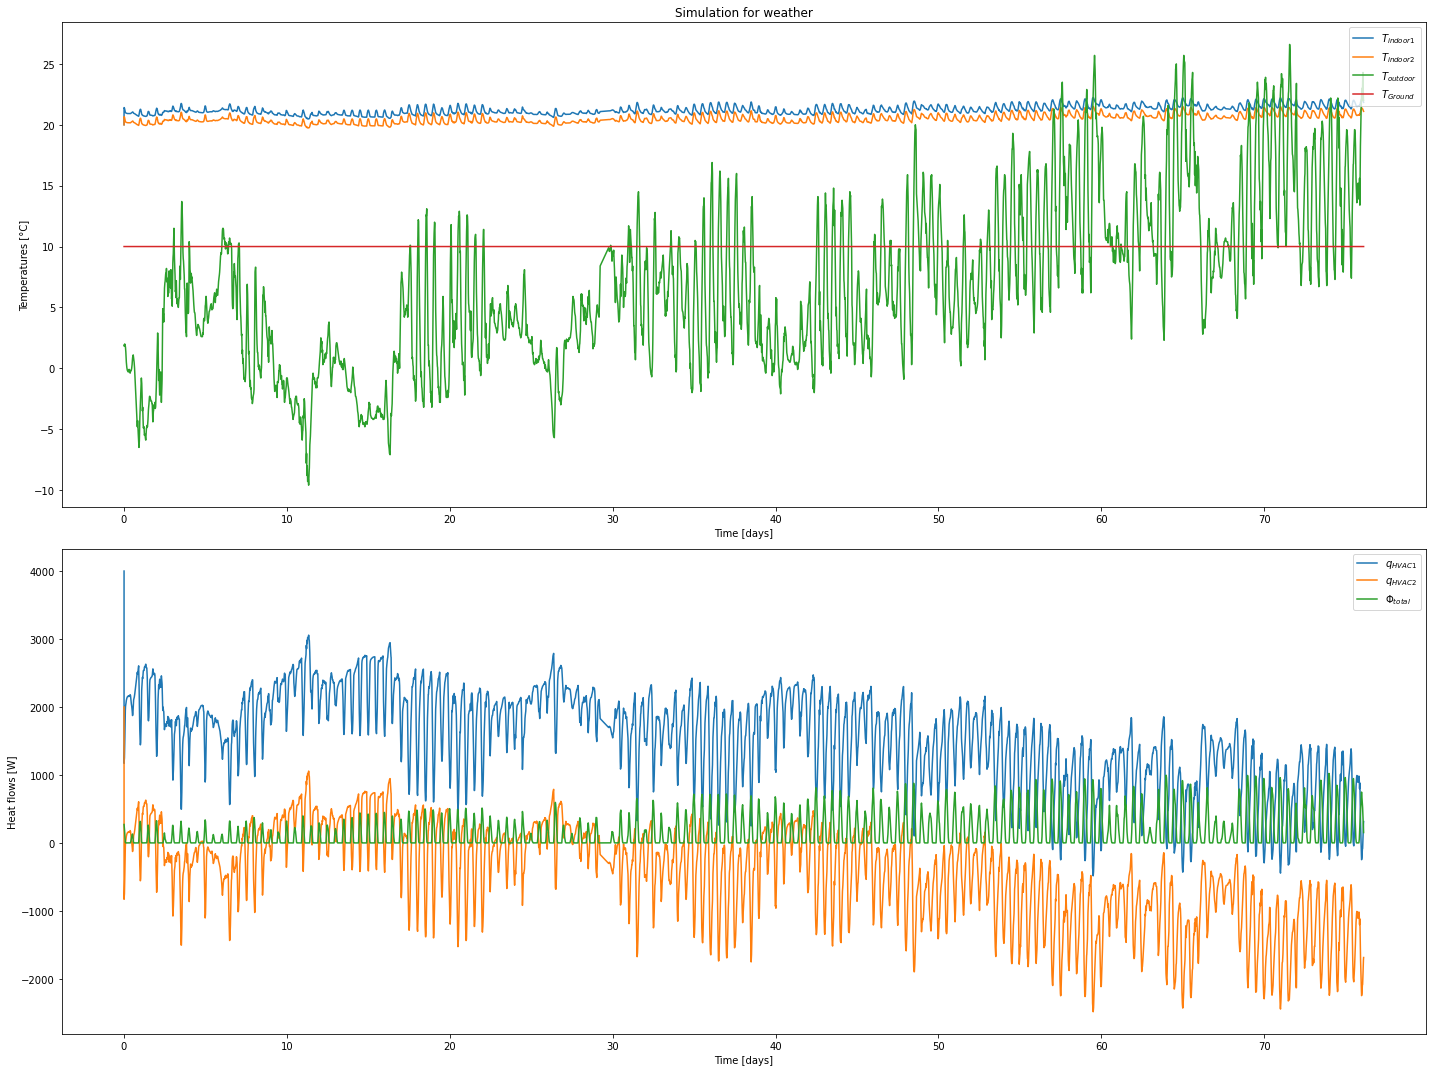

In [50]:
Kp = 2000
choose_Euler = 1
θ_imp = 20 * np.ones([As.shape[0], u.shape[0]])    # implicit Euler in time t

#Conductance Matrix G
# number of temperature nodes and flow branches
R = np.zeros(brn)
R[0] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out']
R[1] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'])
R[2] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                R_cd['Concrete1'] + R_cd['Concrete2'])
R[3] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'])
R[4] = RLWGW
R[5] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in']
R[6] = Rg.iloc[0]['in']
R[7] = Rgs
R[8] = 1 / 2 * R_cd['Glass']
R[9] = 1 / 2 * R_cd['ground']
R[10] = 1 / 4 * R_cd['ground']
R[11] = 1 / 4 * R_cd['ground']
R[12] = 1 / 2 * R_cd['ground'] + 2 * R_cd['Concrete_ground']
R[13] = 1 / 2 * R_cd['Concrete_ground']
R[14] = RLWWF
R[15] = RLWGF
R[16] = Rgr
R[17] = 1
R[18] = Rv
R[19] = Rmid1
R[20] = 1 / 2 * R_cd['Concrete_mid']
R[21] = 1 / 2 * R_cd['Concrete_mid']
R[22] = Rw1.iloc[0]['out'] + Rw2.iloc[0]['out'] + Rroof.iloc[0]['out']
R[23] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'])
R[24] = 1 / 2 * (R_cd['Insulation1'] + R_cd['Insulation2'] +
                 R_cd['Insulation_roof'] + R_cd['Concrete1'] +
                 R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[25] = 1 / 2 * (R_cd['Concrete1'] + R_cd['Concrete2'] + R_cd['Concrete_roof'])
R[26] = Rw1.iloc[0]['in'] + Rw2.iloc[0]['in'] + Rroof.iloc[0]['in']
R[27] = RLWGW
R[28] = Rg.iloc[0]['in']
R[29] = Rgs
R[30] = 1 / 2 * R_cd['Glass']
R[31] = Rv
R[32] = 1
R[33] = Rmid2
R[34] = RLWWF
R[35] = RLWGF
R[36] = RLWWC
R[37] = RLWGC
R[38] = RLWFC
G = np.diag(np.reciprocal(R))
G[17, 17] = Kp
G[32, 32] = Kp
# Temperature Source Vector b
b = np.zeros(brn)       # size defined by branches
b[[0, 7, 9, 17, 18, 22, 29, 31, 32]] = 1   # branches with temperature sources

# Heat flow source Vector f
f = np.zeros(nds)         # size defined by nodes
f[[0, 3, 6, 14, 17, 20]] = 1       # nodes with heat-flow sources

# Output Vector y
y = np.zeros(nds)       # size defined by nodes
y[[5, 19]] = 1              # nodes (temperatures) of interest


# State Space representation for the DAE
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Input conditions
data['Ti1'] = 22 * np.ones(data.shape[0])
data['Ti2'] = 21 * np.ones(data.shape[0])
data['TG'] = 10 * np.ones(data.shape[0])
To = data['To']
Ti1 = data['Ti1']
Ti2 = data['Ti2']
TG = data['TG']
Φo1 = α_wSW * (Sw1 + Sw2) * data['EtotWall']
Φo2 = α_wSW * Sg * data['Etot'] + Φo1
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['EtotWall']
Φa = α_gSW * wall['Surface']['Glass'] * data['EtotWall']
u = pd.concat([To, To, TG, Ti1, To, To, To, To, Ti2, Φo1, Φi, Φa, Φo2, Φi, Φa],
              axis=1)
u.columns.values[[9, 10, 11, 12, 13, 14]] = ['Φo1', 'Φi', 'Φa', 'Φo2', 'Φi', 'Φa']

# Initial Conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
if choose_Euler == 1:
    for k in range(u.shape[0] - 1):
        θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k] + dt * Bs @ u.iloc[k, :]

    y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_exp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_exp[0, :])
elif choose_Euler == 0:
    for k in range(u.shape[0] - 1):
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k] + dt * Bs @ u.iloc[k, :])
    
    y_imp = Cs @ θ_imp + Ds @  u.to_numpy().T
    q_HVAC1 = Kp * (data['Ti1'] - y_imp[0, :])
    q_HVAC2 = Kp * (data['Ti2'] - y_imp[0, :])
    t = dt * np.arange(data.shape[0])   # time vector
    
fig, axs = plt.subplots(2, 1,figsize=(20, 15))
if choose_Euler == 1:
    # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_exp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
elif choose_Euler == 0:
        # plot indoor and outdoor temperature
    axs[0].plot(t / 3600 / 24, y_imp[0, :], label='$T_{indoor1}$')
    axs[0].plot(t / 3600 / 24, y_imp[1, :], label='$T_{indoor2}$')
    axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
    axs[0].plot(t / 3600 / 24, data['TG'], label='$T_{Ground}$')
    axs[0].set(xlabel='Time [days]',
               ylabel='Temperatures [°C]',
               title='Simulation for weather')
    axs[0].legend(loc='upper right')
# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, q_HVAC1, label='$q_{HVAC1}$')
axs[1].plot(t / 3600 / 24, q_HVAC2, label='$q_{HVAC2}$')
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 9: Simulation of the building with explicit method and different room temperature setpoints.

Figure 9 shows a very interesting result. Here you can clearly see that if a lower setpoint temperature is set in one room, less energy is needed because the other room is also heating it. This even leads to overheating in the upper room and the control system tries to cool the room temperature.

## Discussion

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$). The HVAC system of Floor 1 has an impact on the energy consumption of Floor 2. If the lower room is heated to a higher temperature than the room above, the 2nd room will overheat. This implies that energy is needed to heat the lower room and to cool the upper room in order to reach the set temperature.

## Possible improvements for the model
The model is a very simplified 2-storey building. Many assumptions have been made to simplify the model. Among others, the following points could be added to get more realistic results:
- Add a control algorithm for the HVAC controller.
     - cool lock in winter
     - match upper and lower floor setpoints
- Insulation layer from foundation to ground
- Influence of outdoor temperature and irradiation on the surfaces near the ground layers
- different rooms inside the building with individual temperature controllers


## References
[1]  T. L. Bergman,  A. S.Lavine, F. P. Incropera et al, 'Fundamentals of Heat and Mass Transfer', John Wiley and Sons, 2011, ISBN13: 978-0470-50197-9